In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [28]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [29]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [7]:
jobids = []
params = []
data_xx = []
data_zz = []
N = 13
folder_xx = datapath/"xx"
folder_zz = datapath/"zz"
files_xx = ["128577_N13_ED.jld2","128579_N13_ED.jld2","128578_N13_ED.jld2","128580_N13_ED.jld2",
"128594_N13_ED.jld2","128595_N13_ED.jld2","128676_N13_ED.jld2","128675_N13_ED.jld2"] #obc, nn_obc, pbc, nn_pbc, XXX, XYZ, XYY, XYZ
for (i,file) in enumerate(files_xx):
    with h5py.File(folder_xx/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_xx.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
files_zz = ["128583_N13_ED.jld2","128586_N13_ED.jld2","128584_N13_ED.jld2","128587_N13_ED.jld2",
"128593_N13_ED.jld2","128597_N13_ED.jld2","128677_N13_ED.jld2","128674_N13_ED.jld2"] #obc, nn_obc, pbc, nn_pbc, XXX, XYZ, XYY, XYZ
for (i,file) in enumerate(files_zz):
    with h5py.File(folder_zz/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_zz.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)
xcenter = N//2

In [8]:
params

[(13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'x', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.),
 (13, 1, b'z', 0.)]

In [9]:
N = 13
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

## ZZ Commutator

In [10]:
res_zz = data_zz[0][:,:,0]
res_zz_nn = data_zz[1][:,:,0]
red_zz = np.zeros((res_zz.shape[0],N//2+1))
red_zz_nn = np.zeros((res_zz_nn.shape[0],N//2+1))

res_zz_pbc = data_zz[2][:,:,0]
res_zz_nnpbc = data_zz[3][:,:,0]
red_zz_pbc = np.zeros((res_zz_pbc.shape[0],N//2+1))
red_zz_nnpbc = np.zeros((res_zz_nnpbc.shape[0],N//2+1))

res_zz_xxx = data_zz[4][:,:,0]
red_zz_xxx = np.zeros((res_zz_xxx.shape[0],N//2+1))
res_zz_xyz = data_zz[5][:,:,0]
red_zz_xyz = np.zeros((res_zz_xyz.shape[0],N//2+1))

res_zz_xyy = data_zz[6][:,:,0]
red_zz_xyy = np.zeros((res_zz_xyy.shape[0],N//2+1))
res_zz_xyz2 = data_zz[7][:,:,0]
red_zz_xyz2 = np.zeros((res_zz_xyz2.shape[0],N//2+1))


for j in range(0,N//2):
    red_zz[:,j] = 0.5*(res_zz[:,j]+res_zz[:,N-j-1])
    red_zz_nn[:,j] = 0.5*(res_zz_nn[:,j]+res_zz_nn[:,N-j-1])
    red_zz_pbc[:,j] = 0.5*(res_zz_pbc[:,j]+res_zz_pbc[:,N-j-1])
    red_zz_nnpbc[:,j] = 0.5*(res_zz_nnpbc[:,j]+res_zz_nnpbc[:,N-j-1])
    red_zz_xxx[:,j] = 0.5*(res_zz_xxx[:,j]+res_zz_xxx[:,N-j-1])
    red_zz_xyz[:,j] = 0.5*(res_zz_xyz[:,j]+res_zz_xyz[:,N-j-1])
    red_zz_xyy[:,j] = 0.5*(res_zz_xyy[:,j]+res_zz_xyy[:,N-j-1])
    red_zz_xyz2[:,j] = 0.5*(res_zz_xyz2[:,j]+res_zz_xyz2[:,N-j-1])
red_zz[:,N//2] = res_zz[:,N//2]
red_zz_nn[:,N//2] = res_zz_nn[:,N//2]
red_zz_pbc[:,N//2] = res_zz_pbc[:,N//2]
red_zz_nnpbc[:,N//2] = res_zz_nnpbc[:,N//2]
red_zz_xxx[:,N//2] = res_zz_xxx[:,N//2]
red_zz_xyz[:,N//2] = res_zz_xyz[:,N//2]
red_zz_xyy[:,N//2] = res_zz_xyy[:,N//2]
red_zz_xyz2[:,N//2] = res_zz_xyz2[:,N//2]

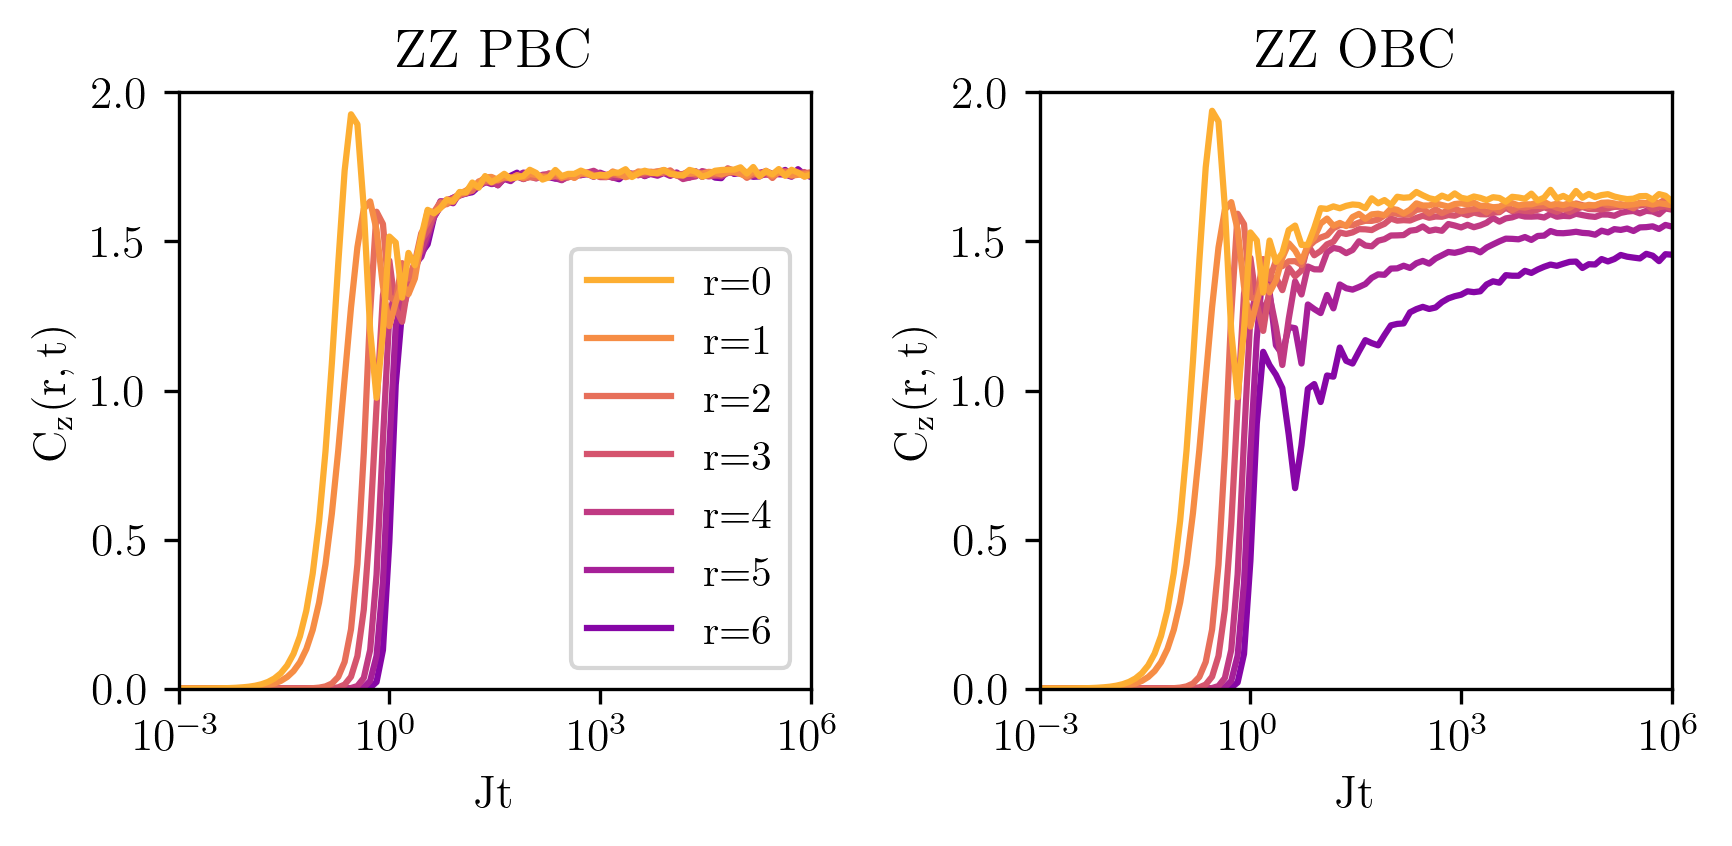

In [11]:
fig, axs = plt.subplots(1, 2,figsize=set_size(subplots=(1,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0].plot(T,red_zz_pbc[:,j],label="r={}".format(rvals[j]))

axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[0].set_title("ZZ PBC")
axs[0].set_xlim(1e-3,1e6)
axs[0].set_ylim(0,2)
handles, labels = axs[0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1].plot(T,red_zz[:,j],label="r={}".format(rvals[j]))

axs[1].set_xlabel(r"Jt")
axs[1].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[1].set_title("ZZ OBC")
axs[1].set_xlim(1e-3,1e6)
axs[1].set_ylim(0,2)

plt.tight_layout()
plt.savefig(figurepath/"OBC_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)

# XX Commutator

In [12]:
res_xx = data_xx[0][:,:,0]
res_xx_nn = data_xx[1][:,:,0]
red_xx = np.zeros((res_xx.shape[0],N//2+1))
red_xx_nn = np.zeros((res_xx_nn.shape[0],N//2+1))

res_xx_pbc = data_xx[2][:,:,0]
res_xx_nnpbc = data_xx[3][:,:,0]
red_xx_pbc = np.zeros((res_xx_pbc.shape[0],N//2+1))
red_xx_nnpbc = np.zeros((res_xx_nnpbc.shape[0],N//2+1))

res_xx_xxx = data_xx[4][:,:,0]
red_xx_xxx = np.zeros((res_xx_xxx.shape[0],N//2+1))
res_xx_xyz = data_xx[5][:,:,0]
red_xx_xyz = np.zeros((res_xx_xyz.shape[0],N//2+1))

res_xx_xyy = data_xx[6][:,:,0]
red_xx_xyy = np.zeros((res_xx_xyy.shape[0],N//2+1))
res_xx_xyz2 = data_xx[7][:,:,0]
red_xx_xyz2 = np.zeros((res_xx_xyz2.shape[0],N//2+1))

for j in range(0,N//2):
    red_xx[:,j] = 0.5*(res_xx[:,j]+res_xx[:,N-j-1])
    red_xx_nn[:,j] = 0.5*(res_xx_nn[:,j]+res_xx_nn[:,N-j-1])
    red_xx_pbc[:,j] = 0.5*(res_xx_pbc[:,j]+res_xx_pbc[:,N-j-1])
    red_xx_nnpbc[:,j] = 0.5*(res_xx_nnpbc[:,j]+res_xx_nnpbc[:,N-j-1])
    red_xx_xxx[:,j] = 0.5*(res_xx_xxx[:,j]+res_xx_xxx[:,N-j-1])
    red_xx_xyz[:,j] = 0.5*(res_xx_xyz[:,j]+res_xx_xyz[:,N-j-1])
    red_xx_xyy[:,j] = 0.5*(res_xx_xyy[:,j]+res_xx_xyy[:,N-j-1])
    red_xx_xyz2[:,j] = 0.5*(res_xx_xyz2[:,j]+res_xx_xyz2[:,N-j-1])
red_xx[:,N//2] = res_xx[:,N//2]
red_xx_nn[:,N//2] = res_xx_nn[:,N//2]
red_xx_pbc[:,N//2] = res_xx_pbc[:,N//2]
red_xx_nnpbc[:,N//2] = res_xx_nnpbc[:,N//2]
red_xx_xxx[:,N//2] = res_xx_xxx[:,N//2]
red_xx_xyz[:,N//2] = res_xx_xyz[:,N//2]
red_xx_xyy[:,N//2] = res_xx_xyy[:,N//2]
red_xx_xyz2[:,N//2] = res_xx_xyz2[:,N//2]

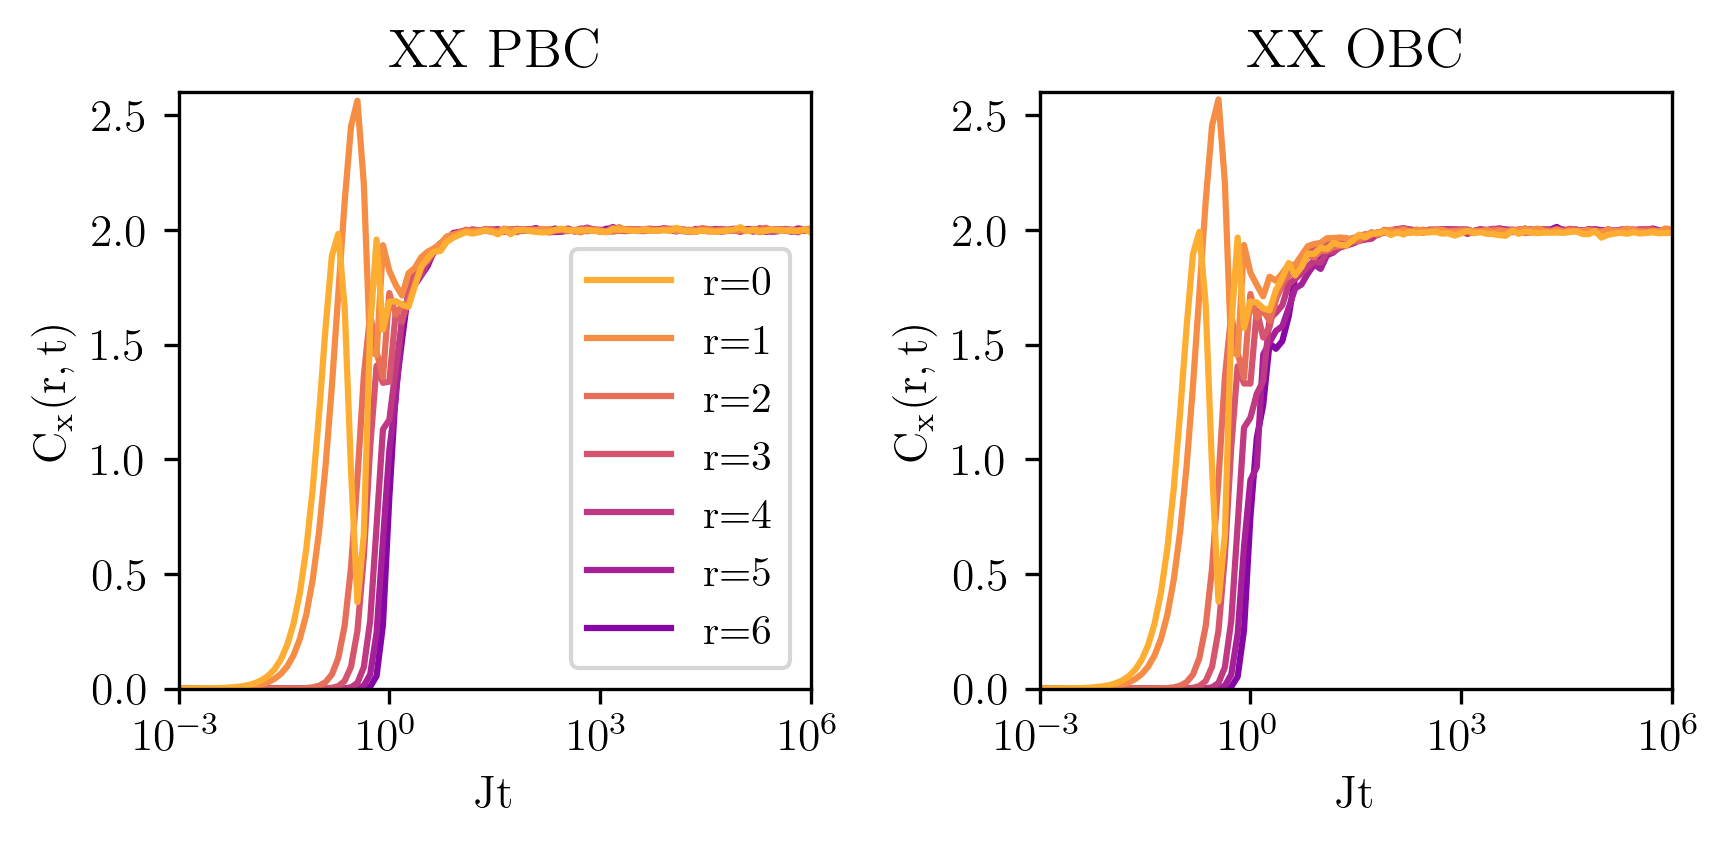

In [13]:
fig, axs = plt.subplots(1, 2,figsize=set_size(subplots=(1,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0].plot(T,red_xx_pbc[:,j],label="r={}".format(rvals[j]))

handles, labels = axs[0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title("XX PBC")
axs[0].set_xlim(1e-3,1e6)
axs[0].set_ylim(0,2.6)


axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1].plot(T,red_xx[:,j],label="r={}".format(rvals[j]))

axs[1].set_xlabel(r"Jt")
axs[1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[1].set_title("XX OBC")
axs[1].set_xlim(1e-3,1e6)
axs[1].set_ylim(0,2.6)





plt.tight_layout()


# Symmetries

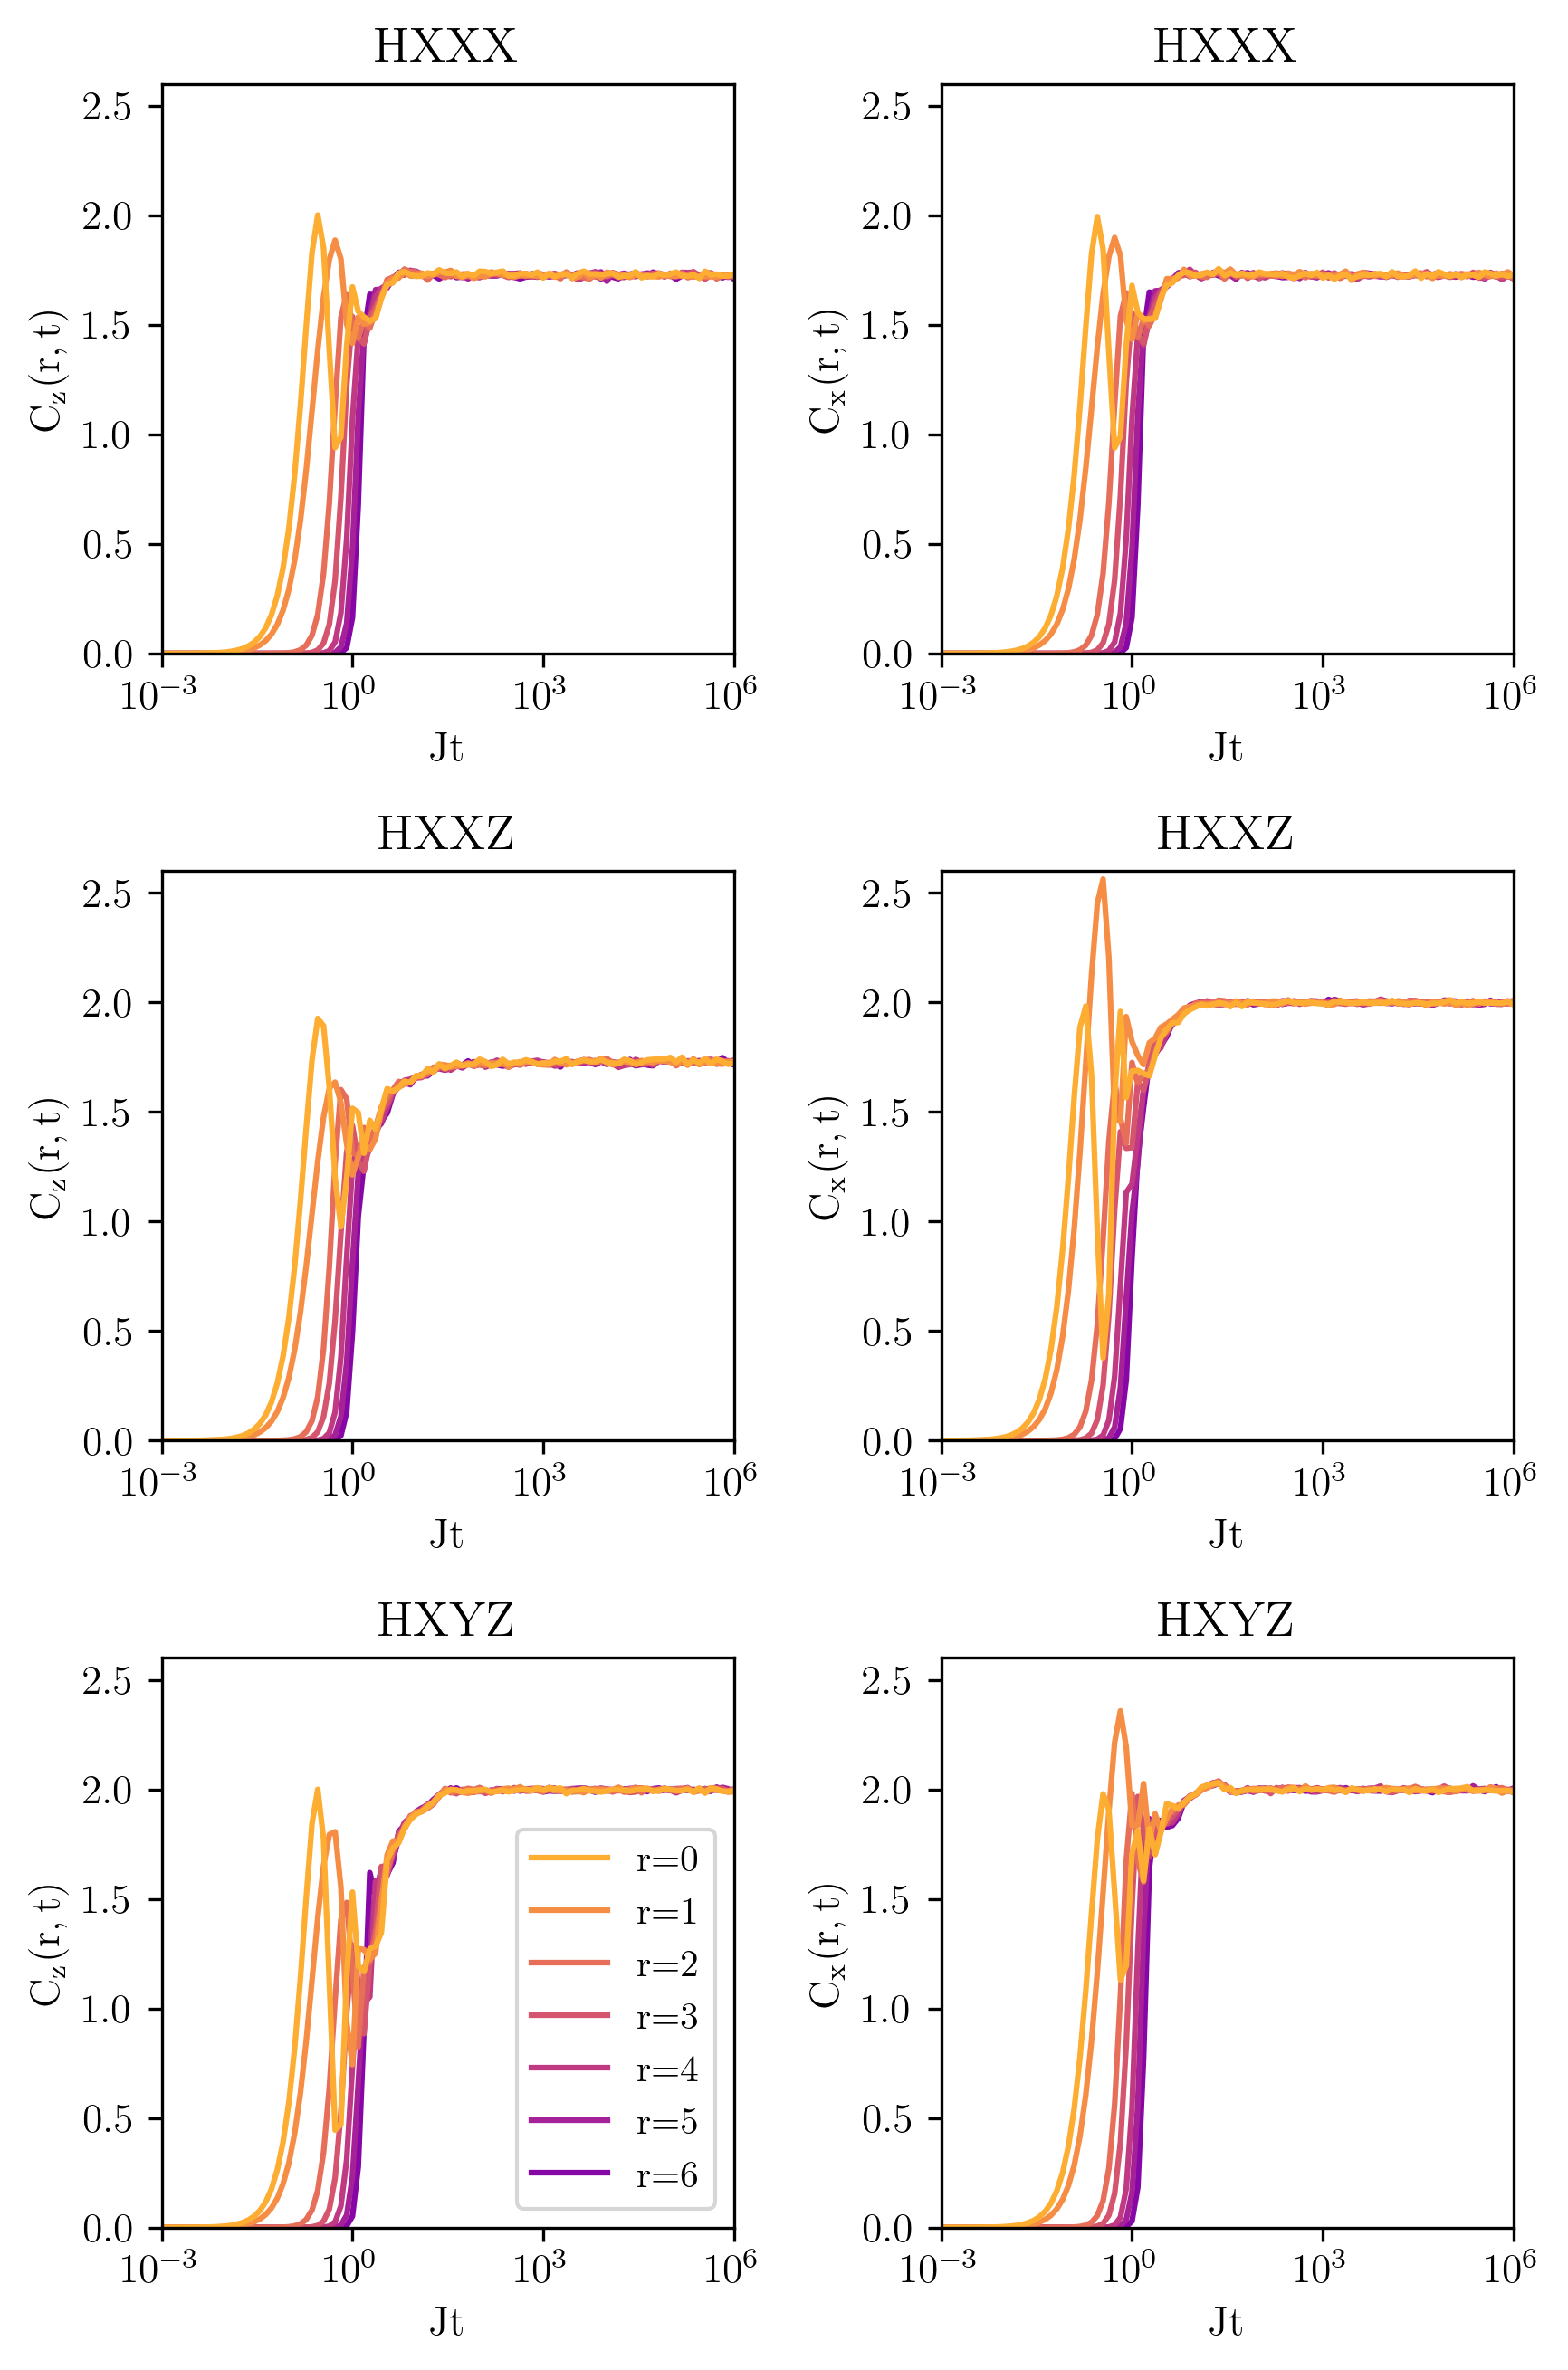

In [14]:
fig, axs = plt.subplots(3, 2,figsize=set_size(subplots=(3,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,0].plot(T,res_zz_xxx[:,j],label="r={}".format(rvals[j]))

axs[0,0].set_xlabel(r"Jt")
axs[0,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[0,0].set_title("HXXX")
axs[0,0].set_xlim(1e-3,1e6)
axs[0,0].set_ylim(0,2.6)


axs[0,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,1].plot(T,res_xx_xxx[:,j],label="r={}".format(rvals[j]))

axs[0,1].set_xlabel(r"Jt")
axs[0,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0,1].set_title("HXXX")
axs[0,1].set_xlim(1e-3,1e6)
axs[0,1].set_ylim(0,2.6)


axs[1,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,0].plot(T,res_zz_pbc[:,j],label="r={}".format(rvals[j]))

axs[1,0].set_xlabel(r"Jt")
axs[1,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[1,0].set_title("HXXZ")
axs[1,0].set_xlim(1e-3,1e6)
axs[1,0].set_ylim(0,2.6)


axs[1,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,1].plot(T,res_xx_pbc[:,j],label="r={}".format(rvals[j]))

axs[1,1].set_xlabel(r"Jt")
axs[1,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[1,1].set_title("HXXZ")
axs[1,1].set_xlim(1e-3,1e6)
axs[1,1].set_ylim(0,2.6)


axs[2,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,0].plot(T,res_zz_xyz2[:,j],label="r={}".format(rvals[j]))

handles, labels = axs[0,0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[2,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
axs[2,0].set_xlabel(r"Jt")
axs[2,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[2,0].set_title("HXYZ")
axs[2,0].set_xlim(1e-3,1e6)
axs[2,0].set_ylim(0,2.6)


axs[2,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,1].plot(T,res_xx_xyz2[:,j],label="r={}".format(rvals[j]))

axs[2,1].set_xlabel(r"Jt")
axs[2,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[2,1].set_title("HXYZ")
axs[2,1].set_xlim(1e-3,1e6)
axs[2,1].set_ylim(0,2.6)


plt.tight_layout()
plt.savefig(figurepath/"symmetries_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)

In [15]:
print("ZZ\n")
print("XXX",np.mean(res_zz_xxx[66:]),"\n")
print("XXZ",np.mean(res_zz_pbc[66:]),"\n")
print("XYZ",np.mean(res_zz_xyz2[66:]),"\n")

ZZ

XXX 1.7264978449685677 

XXZ 1.7267547578749658 

XYZ 1.9976446836559052 



In [16]:
print("XX\n")
print("XXX",np.mean(res_xx_xxx[66:]),"\n")
print("XXZ",np.mean(res_xx_pbc[66:]),"\n")
print("XYZ",np.mean(res_xx_xyz2[66:]),"\n")

XX

XXX 1.7260654375446465 

XXZ 1.9993699626159978 

XYZ 1.9987050773834143 



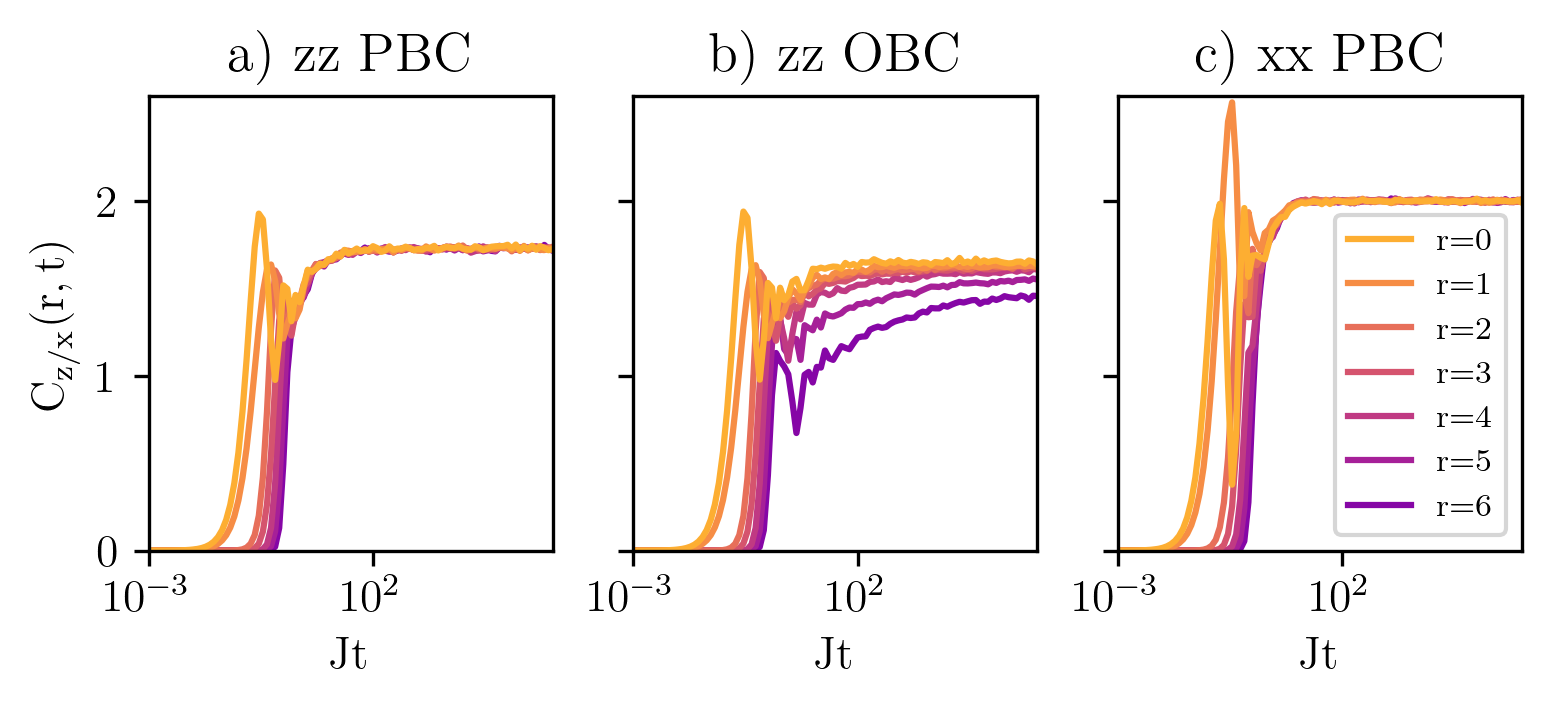

In [54]:
fig, axs = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi = 300,sharey=True)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0].plot(T,res_zz_pbc[:,j],label="r={}".format(rvals[j]))

axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_{z/x}(r,t)}$")
axs[0].set_title("a) zz PBC")
axs[0].set_xlim(1e-3,1e6)
axs[0].set_ylim(0,2.6)

axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1].plot(T,red_zz[:,j],label="r={}".format(rvals[j]))

axs[1].set_xlabel(r"Jt")
#axs[1].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[1].set_title("b) zz OBC")
axs[1].set_xlim(1e-3,1e6)
axs[1].set_ylim(0,2.6)


axs[2].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2].set_xscale("log")
for j in range(0,N//2+1):
    axs[2].plot(T,res_xx_pbc[:,j],label="r={}".format(rvals[j]))

axs[2].set_xlabel(r"Jt")
#axs[2].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[2].set_title("c) xx PBC")
axs[2].set_xlim(1e-3,1e6)
axs[2].set_ylim(0,2.6)
handles, labels = axs[2].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[2].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "lower right",fontsize="x-small")

#plt.subplots_adjust(wspace=0.4)
plt.savefig(figurepath/"zz_vs_xx.pdf",format="pdf",bbox_inches='tight',dpi=600)